In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Device configuration (GPU o CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
# Ruta donde se almacenarán los datos CelebAGaze
root = 'datasets/CelebAGaze'

class EnsureRGBChannels:
    def __call__(self, image):
        if image.mode != 'RGB':
            image = image.convert('RGB')
        return image

# Transformaciones de datos
transform = transforms.Compose([
        EnsureRGBChannels(),
        transforms.Resize((128 , 128)),
        transforms.ToTensor()
    ])

# Cargar datos de entrenamiento
train_dataset = ImageFolder(root=root, transform=transform)

In [3]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 20000
    Root location: datasets/CelebAGaze
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, trainset, device=device):
        self.dev = device
        self.imgs = torch.cat([torch.as_tensor(i[0], dtype=torch.float).view(1, -1) for i in trainset], dim=0).to(self.dev)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, ix):
        return self.imgs[ix]

In [5]:
# Crear dataset 
train = Dataset(train_dataset)
len(train)

20000

In [6]:
img = train[0]
img.shape, img.dtype, img.max(), img.min()

(torch.Size([49152]),
 torch.float32,
 tensor(0.9529, device='cuda:0'),
 tensor(0.0196, device='cuda:0'))

In [7]:
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

imgs = next(iter(dataloader))
imgs.shape

torch.Size([32, 49152])

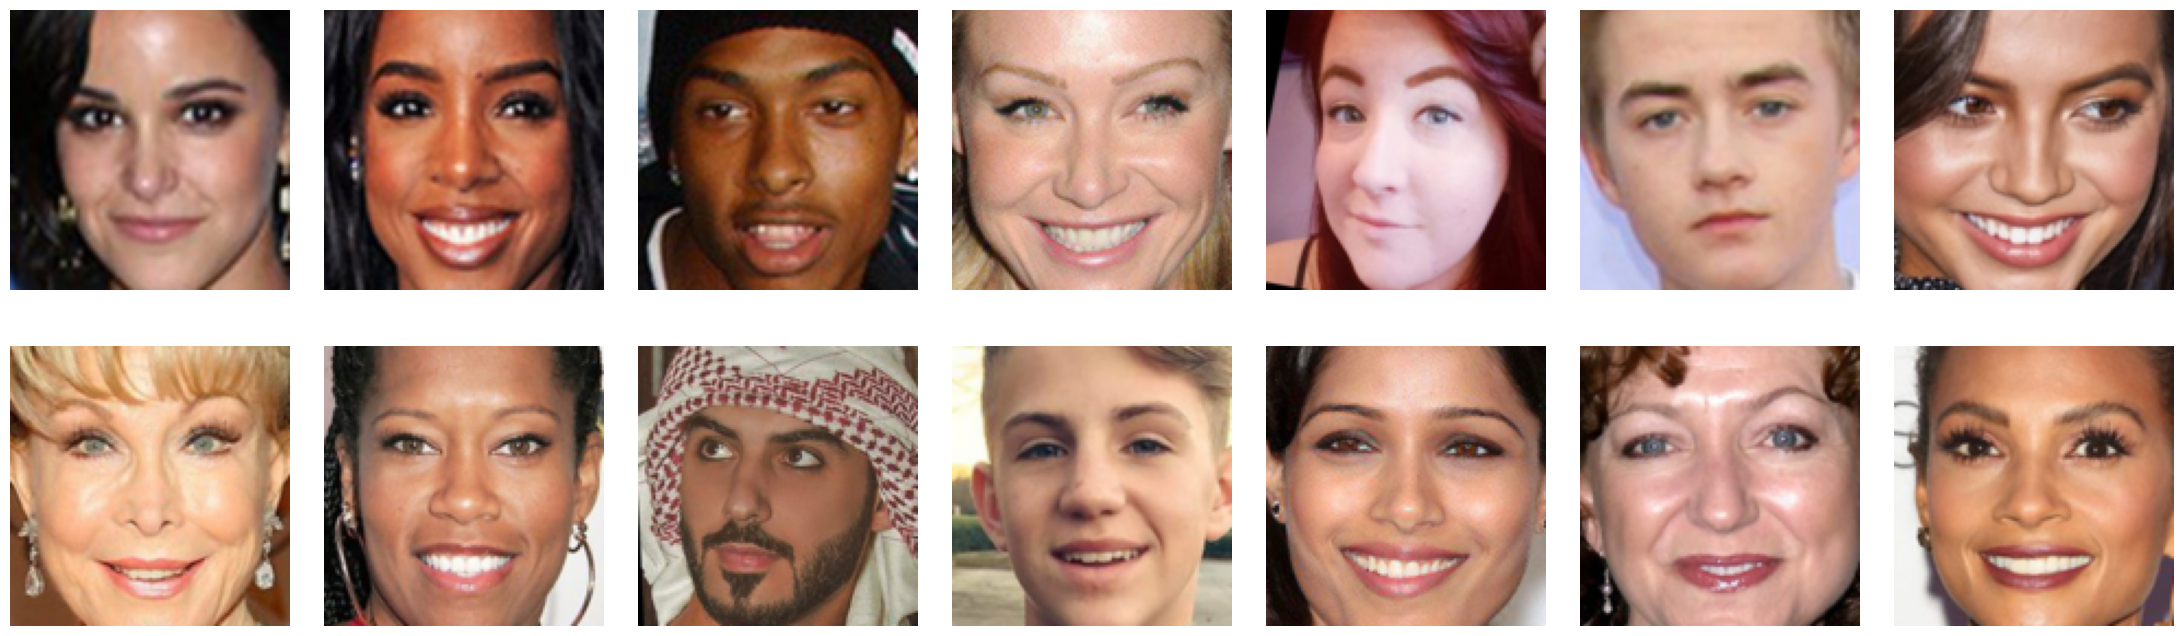

In [9]:
import random
import matplotlib.pyplot as plt

r, c = 2, 7
plt.figure(figsize=(c * 4, r * 4))  # Aumenta el tamaño de la figura para imágenes de 128x128
for row in range(r):
    for col in range(c):
        index = c * row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(train) - 1)
        img = train[ix].reshape(3, 128, 128).cpu().numpy()  # Reshape para obtener la imagen 3x128x128
        img = img.transpose(1, 2, 0)  # Cambia el orden de los canales de color a (128, 128, 3)
        plt.imshow(img)  # No es necesario especificar cmap para mostrar en color
        plt.axis("off")
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

In [24]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 100
        self.inp = nn.Sequential(
            nn.Linear(self.input_size, 256 * 16 * 16),  # Aumentamos el número de canales a 256
            nn.BatchNorm1d(256 * 16 * 16),
        )
        self.main = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False),  # 3 canales para color (RGB)
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.inp(x)
        x = x.view(-1, 256, 8, 8)  # Dimensiones ajustadas para la red
        x = self.main(x)
        x = x.view(x.size(0), -1)  # Ajustamos las dimensiones a 128x128 y 3 canales para color
        return x

In [25]:
generator = Generator()
output = generator(torch.randn(1, 100))
output.shape

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 65536])

In [51]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),  # Cambio en el número de canales de entrada a 3
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        )
        self.out = nn.Sequential(
            nn.Linear(128 * 32 * 32, 1),  # Cambio en el tamaño de entrada (128x32x32)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x


In [52]:
discriminator = Discriminator()
output = discriminator(torch.randn(64, 3, 128, 128))
output.shape

torch.Size([64, 1])

In [77]:
from tqdm import tqdm
import numpy as np

def fit(g, d, dataloader, epochs=30, crit=None):
    g.to(device)
    d.to(device)
    g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
    d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)
    crit = nn.BCEWithLogitsLoss() if crit is None else crit
    g_loss, d_loss = [], []
    
    hist = {'g_loss': [], 'd_loss': []}
    
    for epoch in range(1, epochs + 1):
        g_losses = []
        d_losses = []
        
        with tqdm(total=len(dataloader), desc=f'Epoch {epoch}/{epochs}', unit='batch') as pbar:
            for X in dataloader:
                g.eval()
                d.train()
                
                noise = torch.randn((X.size(0), g.input_size)).to(device)
                generated_images = g(noise)
                
                d_input = torch.cat([generated_images, X.view(X.size(0), -1)]).to(device)
                d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1, 1).to(device)
                
                d_optimizer.zero_grad()
                d_output = d(d_input)
                d_loss_value = crit(d_output, d_gt)
                d_loss_value.backward()
                d_optimizer.step()
                d_losses.append(d_loss_value.item())
                
                g.train()
                d.eval()
                
                noise = torch.randn((X.size(0), g.input_size)).to(device)
                generated_images = g(noise)
                
                d_output = d(generated_images)
                g_gt = torch.ones(X.size(0)).view(-1, 1).to(device)
                
                g_optimizer.zero_grad()
                g_loss_value = crit(d_output, g_gt)
                g_loss_value.backward()
                g_optimizer.step()
                g_losses.append(g_loss_value.item())
                
                pbar.set_postfix(g_loss=np.mean(g_losses), d_loss=np.mean(d_losses))
                pbar.update()
                
        hist['g_loss'].append(np.mean(g_losses))
        hist['d_loss'].append(np.mean(d_losses))
    
    return hist

In [78]:
hist = fit(generator, discriminator, dataloader, epochs=1, crit=torch.nn.BCELoss())

Epoch 1/1:   0%|          | 0/625 [00:00<?, ?batch/s]


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 196608 but got size 49152 for tensor number 1 in the list.

In [58]:
import pandas as pd

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

NameError: name 'hist' is not defined

RuntimeError: shape '[256, 256]' is invalid for input of size 196608

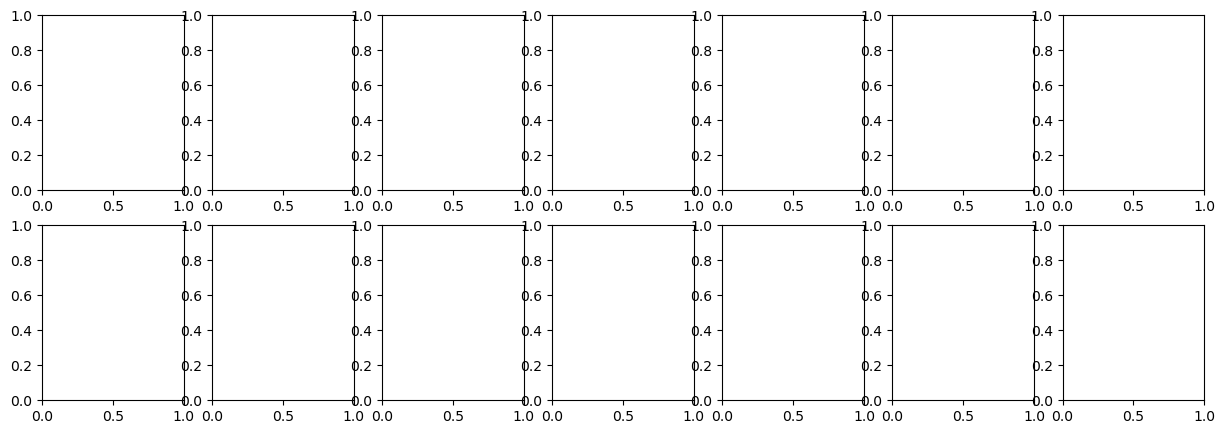

In [59]:
generator.eval()
with torch.no_grad():
    noise = torch.randn((14, generator.input_size)).to(device)
    generated_images = generator(noise)
    fig, axs = plt.subplots(2, 7, figsize=(15, 5))
    i = 0
    for ax in axs:
        for _ax in ax:
            img = generated_images[i].view(256, 256).cpu()
            _ax.imshow(img)
            i += 1
    plt.show()